# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [128]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [129]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [130]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [131]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [132]:
dset = d3w('../dataset')
with open('dset_tfm1.pkl', 'wb') as f:
  pickle.dump(dset, f)
dset.all.groupby('label').path.count()

..\dataset\0
..\dataset\1
..\dataset\2
..\dataset\3
..\dataset\4
..\dataset\5
..\dataset\6
..\dataset\7
..\dataset\8


label
0    597
1    129
2     38
3    106
4    344
5    451
6    221
7     14
8     81
Name: path, dtype: int64

Subset for labels 0 (Normal conditions) and 2 (SPURIOUS CLOSURE OF DHSV).

In [133]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(label=[0, 2], test_size=0.5, val_size=0.1, sample_n=None)

Instances Train: 285  Test: 318  Validation: 32


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [134]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [135]:
gen = CustomGen(train_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2017-02-19 17:00:00 {'P-PDG': nan, 'P-TPT': -0.23436637662801296, 'T-TPT': 0.19054200007020025, 'P-MON-CKP': -0.1345434835754911, 'T-JUS-CKP': -2.8958870683795226, 'P-JUS-CKGL': -0.17828843163612215, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-02-19 17:01:00 {'P-PDG': nan, 'P-TPT': -0.16973790883164525, 'T-TPT': 0.2005539020052048, 'P-MON-CKP': -0.570060054434674, 'T-JUS-CKP': -0.8895174760871105, 'P-JUS-CKGL': -0.1663972179415233, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-02-19 17:02:00 {'P-PDG': nan, 'P-TPT': -0.05407532344644881, 'T-TPT': 0.21856513525694662, 'P-MON-CKP': -1.7884666199696388, 'T-JUS-CKP': 1.337625154962536, 'P-JUS-CKGL': -0.14484282848764232, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-02-19 17:03:00 {'P-PDG': nan, 'P-TPT': 0.06161528946297386, 'T-TPT': 0.23662095076948073, 'P-MON-CKP': -0.43417700062266384, 'T-JUS-CKP': 1.89495050868713, 'P-JUS-CKGL': -0.12331764552261187, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


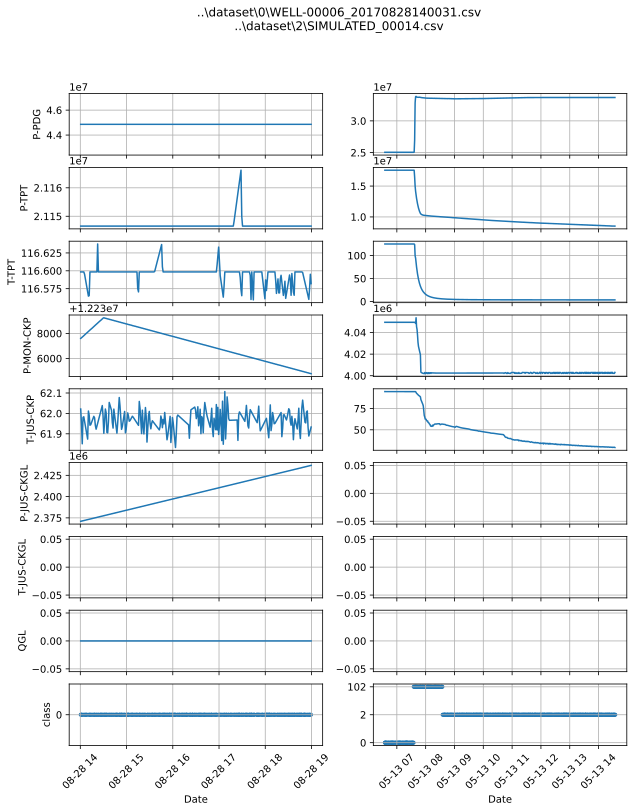

In [136]:
gen.plot([0,7])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [137]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, report, ifiles, model

In [57]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(tree.HoeffdingTreeClassifier(delta=1.E-4))
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
model = imblearn.RandomOverSampler((tree.HoeffdingTreeClassifier(delta=1.E-4)),
        desired_dist={0: 0.4, 102: 0.2, 2: 0.4}, seed=200560)


flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 15
epochs = 15

reports = epochs*[0]
reportsv = epochs*[0]
models = []
for epoch in range(epochs):
    print('\nepoch: {}\n'.format(epoch+1))
    ys, y_preds, accuracies, reports[epoch], ifiles, model, df = fit_model(train_df, flist, 'class', window_size,
                                                                  model, dfB=True, EvalB=False)
    models.append(model)
    yse, y_predse, accuraciese, reportsv[epoch], _, _, v_df = fit_model(val_df, flist, 'class', window_size, 
                                                                model, dfB=True, EvalB=True)    


epoch: 1

files learned  285 / 285
 BalancedAccuracy: 91.13%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.61%   96.58%   98.07%     71134  
     2.0      69.19%   98.16%   81.16%      2612  
   102.0      40.67%   78.64%   53.61%      1147  
                                                  
   Macro      69.82%   91.13%   77.61%            
   Micro      96.36%   96.36%   96.36%            
Weighted      97.64%   96.36%   96.80%            

                 96.36% accuracy                  
files learned  32 / 32
 BalancedAccuracy: 43.83%

            Precision   Recall   F1       Support  
                                                  
     0.0      93.89%   96.07%   94.97%      8351  
     2.0     100.00%    0.80%    1.60%       373  
   102.0      19.85%   34.60%   25.23%       237  
                                                  
   Macro      71.25%   43.83%   40.60%            
   Micro      90.

files learned  32 / 32
 BalancedAccuracy: 77.50%

            Precision   Recall    F1       Support  
                                                   
     0.0      99.57%    99.16%   99.36%      8351  
     2.0      66.02%   100.00%   79.53%       373  
   102.0     100.00%    33.33%   50.00%       237  
                                                   
   Macro      88.53%    77.50%   76.30%            
   Micro      97.46%    97.46%   97.46%            
Weighted      98.18%    97.46%   97.23%            

                  97.46% accuracy                  

epoch: 9

files learned  285 / 285
 BalancedAccuracy: 97.71%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.91%   99.28%   99.59%     71134  
     2.0      90.81%   98.39%   94.45%      2612  
   102.0      79.69%   95.47%   86.87%      1147  
                                                  
   Macro      90.14%   97.71%   93.64%            
   Micr

In [61]:
print('epoch    Train       Val')
for i, (x, y) in enumerate(zip(reports, reportsv)):
    print('  {:2d}    {:6.2f}%    {:6.2f}%'.format(i, x.get()*100, y.get()*100))

epoch    Train       Val
   0     91.13%     43.83%
   1     95.13%     43.76%
   2     97.22%     44.16%
   3     97.30%     44.98%
   4     97.75%     45.26%
   5     97.74%     44.98%
   6     98.09%     50.18%
   7     98.24%     77.50%
   8     97.71%     82.70%
   9     97.52%     80.61%
  10     97.65%     81.03%
  11     97.94%     80.52%
  12     97.86%     80.94%
  13     98.00%     80.68%
  14     98.12%     81.10%


In [63]:
model_fitted = deepcopy(models[8])
with open('model_2.pkl', 'wb') as f:
  pickle.dump(model_fitted, f)

In [138]:
if pathlib.Path('model_2.pkl').exists():
  with open('model_2.pkl', 'rb') as f:
    model_fitted = pickle.load(f)

In [139]:
model_fitted.classifier.height

61

In [140]:
yse, y_predse, accuraciese, _, _, _, v_df = fit_model(val_df, flist, 'class', window_size, 
                                                            model_fitted, dfB=True, EvalB=True)    

files learned  32 / 32
 BalancedAccuracy: 82.70%

            Precision   Recall    F1       Support  
                                                   
     0.0      99.98%    99.16%   99.57%      8351  
     2.0      66.37%   100.00%   79.79%       373  
   102.0     100.00%    48.95%   65.72%       237  
                                                   
   Macro      88.78%    82.70%   81.69%            
   Micro      97.87%    97.87%   97.87%            
Weighted      98.58%    97.87%   97.85%            

                  97.87% accuracy                  


In [70]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(yse, y_predse))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      8351
         2.0       0.66      1.00      0.80       373
       102.0       1.00      0.49      0.66       237

    accuracy                           0.98      8961
   macro avg       0.89      0.83      0.82      8961
weighted avg       0.99      0.98      0.98      8961



In [66]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 8046
P-MON-CKP_rSEM 8046
P-MON-CKP_rMax 8046
P-MON-CKP_rMin 8046
T-JUS-CKP_rmean 10282
T-JUS-CKP_rSEM 10282
T-JUS-CKP_rMax 10282
T-JUS-CKP_rMin 10282
P-JUS-CKGL_rmean 23505
P-JUS-CKGL_rSEM 23505
P-JUS-CKGL_rMax 23505
P-JUS-CKGL_rMin 23505
QGL_rmean 23505
QGL_rSEM 23505
QGL_rMax 23505
QGL_rMin 23505
class 0
mean accuracy Random Forest:  1.0
            var    varImp
3    P-PDG_rMin  0.231780
0   P-PDG_rmean  0.142145
1    P-PDG_rSEM  0.112677
2    P-PDG_rMax  0.110884
6    P-TPT_rMax  0.107110
5    P-TPT_rSEM  0.075940
4   P-TPT_rmean  0.054033
9    T-TPT_rSEM  0.043954
11   T-TPT_rMin  0.036446
10   T-TPT_rMax  0.034773
8   T-TPT_rmean  0.029295
7    P-TPT_rMin  0.020962
CPU times: total: 10.7 s
Wall time: 13.3 s


,var,varImp
0,P-PDG,0.597486
1,P-TPT,0.258046
2,T-TPT,0.144468


In [72]:
# Random Forest on validation set
print(classification_report(v_df['class'], forest.predict((v_df[f_list]))))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      8351
         2.0       0.97      0.96      0.97       373
       102.0       0.92      0.54      0.68       237

    accuracy                           0.98      8961
   macro avg       0.96      0.83      0.88      8961
weighted avg       0.98      0.98      0.98      8961



In [181]:
def plot_acc(accuracies, accuraciesD, supt, subt):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(accuracies, label='Predict/Fit')
    plt.plot(accuraciesD, label='Evaluated')
    plt.legend(loc="lower right")
    plt.title(supt + '\n' + subt)
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    plt.show()
    return

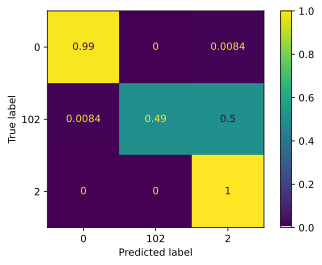

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(yse, y_predse, labels=[0, 102, 2], normalize='true'), 
                       display_labels=[0, 102, 2]).plot()

## Drift test

In [148]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)

In [164]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = drift.EDDM(warm_start=30, alpha=0.8, beta=0.7)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
            n += 1

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, report, ifiles, model

In [165]:
dr = drift_reg()
yse, y_predse, accuraciese, report, ifiles, _, t_df = fit_modelD(test_df, flist, 'class', window_size, 
                                                            model_fitted, dr, dfB=True, EvalB=True)    

files learned  48 / 318
Change detected at index 14285 225, ifile 47, label 0 0.0 WELL-00003_20170813080105
files learned  85 / 318
Change detected at index 24243 228, ifile 84, label 0 0.0 WELL-00008_20170614030135
files learned  103 / 318
Change detected at index 28636 130, ifile 102, label 0 0.0 WELL-00008_20170819070246
files learned  129 / 318
Warning detected at index 35653 43, ifile 128, label 2 102.0 WELL-00011_20140929220121
files learned  136 / 318
Change detected at index 37486 127, ifile 135, label 0 0.0 WELL-00005_20170817080000
files learned  170 / 318
Change detected at index 47668 256, ifile 169, label 0 0.0 WELL-00008_20170612090246
files learned  195 / 318
Change detected at index 54796 142, ifile 194, label 0 0.0 WELL-00005_20170813230000
files learned  224 / 318
Change detected at index 63098 262, ifile 223, label 0 0.0 WELL-00008_20170630080310
files learned  246 / 318
Warning detected at index 69271 47, ifile 245, label 2 102.0 WELL-00011_20140515110134

Change de

In [172]:
# train on complete files detected with drift

res = dr.to_df()

model_fittedD = deepcopy(model_fitted)

drift_files = res.ifile.unique()

t_df['ifile'] = ifiles

for i in t_df[t_df.ifile.isin(drift_files)].index:
    model_fittedD.learn_one(t_df.drop(['class', 'ifile'], axis=1).iloc[i].to_dict(), t_df.iloc[i]['class'])

In [125]:
res = dr.to_df()

model_fittedD = deepcopy(model_fitted)
epochs = 1
last_ifile = -1
for i, rec in res.iterrows():
    print(i, rec['ifile'], rec['i'], rec['n'], rec['warn'], rec['change'])
    if rec['ifile'] != last_ifile:
        ini = -1
        fin = -1
        last_ifile = rec['ifile']
    if rec['warn']:
        ini = rec['i'] - min(30, rec['n'])
    elif rec['change']:
        if ini >= 0:
            fin = rec['i']
        else:
            ini = rec['i'] - min(30, rec['n'])
            fin = rec['i']
    if ini * fin >= 0:
        print('***', ini, fin)
        for epoch in range(epochs):
            for j in range(ini, fin+1):
                model_fittedD.learn_one(t_df.drop('class', axis=1).iloc[j].to_dict(), t_df.iloc[j]['class'])
            

0 47 14285 225 False True
*** 14255 14285
1 84 24243 228 False True
*** 24213 24243
2 102 28636 130 False True
*** 28606 28636
3 128 35653 43 True False
4 135 37486 127 False True
*** 37456 37486
5 169 47668 256 False True
*** 47638 47668
6 194 54796 142 False True
*** 54766 54796
7 223 63098 262 False True
*** 63068 63098
8 245 69271 47 True False
9 245 69288 64 False True
*** 69241 69288
10 264 74528 57 False True
*** 74498 74528
11 280 78512 78 False True
*** 78482 78512


In [173]:
drD = drift_reg()
yseD, y_predseD, accuracieseD, reportD, _, _ = fit_modelD(test_df, flist, 'class', window_size, 
                                                            model_fittedD, drD, dfB=False, EvalB=True)    

files learned  30 / 318
Change detected at index 8780 212, ifile 29, label 0 0.0 WELL-00001_20170422040000

Warning detected at index 8879 311, ifile 29, label 0 0.0 WELL-00001_20170422040000

Change detected at index 8911 343, ifile 29, label 0 0.0 WELL-00001_20170422040000
files learned  48 / 318
Change detected at index 14285 225, ifile 47, label 0 0.0 WELL-00003_20170813080105
files learned  85 / 318
Change detected at index 24243 228, ifile 84, label 0 0.0 WELL-00008_20170614030135
files learned  103 / 318
Change detected at index 28636 130, ifile 102, label 0 0.0 WELL-00008_20170819070246
files learned  129 / 318
Warning detected at index 35653 43, ifile 128, label 2 102.0 WELL-00011_20140929220121
files learned  136 / 318
Change detected at index 37486 127, ifile 135, label 0 0.0 WELL-00005_20170817080000
files learned  140 / 318
Change detected at index 38533 96, ifile 139, label 0 0.0 WELL-00002_20131214180036
files learned  170 / 318
Change detected at index 47668 256, ifile 

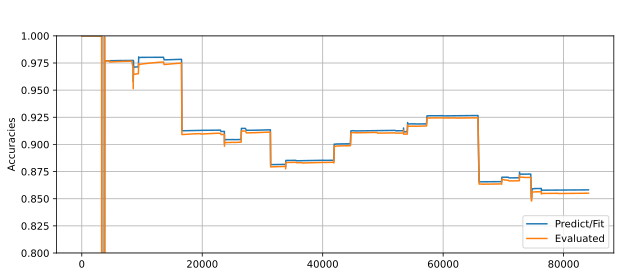

In [182]:
plot_acc(accuraciese, accuracieseD, '', '')

In [ ]:
dr = drift_reg()
lastfile = -1
for i, (ifile, er, y) in enumerate(zip(ifiles, np.not_equal(yse, y_predse), yse)):
    if ifile != lastfile:
        lastfile = ifile
        drd = drift.EDDM(warm_start=30, alpha=0.7, beta=0.6)
        #drd = drift.DDM(warm_start=30, warning_threshold=2, drift_threshold=3)
        #drd = drift.HDDM_A(drift_confidence=0.001, warning_confidence=0.005, two_sided_test=False)
        #drd = drift.HDDM_W(drift_confidence=0.001, warning_confidence=0.005, lambda_val=0.05, two_sided_test=False)
        print_warning = True
        n = 0
    _ = drd.update(er)
    warn = change = False
    if drd.warning_detected and print_warning:
        warn = True
        print(f"Warning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
        print_warning = False
    if drd.drift_detected:
        change = True
        print(f"Change detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
        print_warning = True
    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
    n += 1

res = dr.to_df()

In [180]:
res

,i,n,ifile,label,y,path,warn,change,origin,well
0,14285,225,47,0,0,..\dataset\0\WELL-00003_20170813080105.csv,False,True,R,3
1,24243,228,84,0,0,..\dataset\0\WELL-00008_20170614030135.csv,False,True,R,8
2,28636,130,102,0,0,..\dataset\0\WELL-00008_20170819070246.csv,False,True,R,8
3,35653,43,128,2,102,..\dataset\2\WELL-00011_20140929220121.csv,True,False,R,11
4,37486,127,135,0,0,..\dataset\0\WELL-00005_20170817080000.csv,False,True,R,5
5,47668,256,169,0,0,..\dataset\0\WELL-00008_20170612090246.csv,False,True,R,8
6,54796,142,194,0,0,..\dataset\0\WELL-00005_20170813230000.csv,False,True,R,5
7,63098,262,223,0,0,..\dataset\0\WELL-00008_20170630080310.csv,False,True,R,8
8,69271,47,245,2,102,..\dataset\2\WELL-00011_20140515110134.csv,True,False,R,11
9,69288,64,245,2,102,..\dataset\2\WELL-00011_20140515110134.csv,False,True,R,11


In [175]:
res.groupby(['origin', 'label', 'y', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin', 'label', 'y'])['path'].count() * 100

origin  label  y    warn   change
R       0      0    False  True      100.0
        2      102  False  True       50.0
                    True   False      50.0
Name: path, dtype: float64

In [176]:
res.groupby(['origin', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin'])['path'].count() * 100

origin  warn   change
R       False  True      83.333333
        True   False     16.666667
Name: path, dtype: float64

In [177]:
res.groupby(['label', 'warn', 'change'])['path'].count() /\
            res.groupby(['label'])['path'].count() * 100

label  warn   change
0      False  True      100.0
2      False  True       50.0
       True   False      50.0
Name: path, dtype: float64

In [178]:
res.groupby(['y', 'warn', 'change'])['path'].count() /\
            res.groupby(['y'])['path'].count() * 100

y    warn   change
0    False  True      100.0
102  False  True       50.0
     True   False      50.0
Name: path, dtype: float64

In [179]:
res.groupby(['well', 'warn', 'change'])['path'].count() /\
            res.groupby(['well'])['path'].count() * 100

well  warn   change
3     False  True      100.000000
5     False  True      100.000000
8     False  True      100.000000
11    False  True       33.333333
      True   False      66.666667
13    False  True      100.000000
Name: path, dtype: float64